In [ ]:
import urllib
from keras.layers import Dense, Activation
from keras.layers.recurrent import SimpleRNN
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import numpy as np
from keras import backend as K
from keras.preprocessing.text import * 

In [ ]:
lines = []

req = urllib.request.urlopen('http://www.gutenberg.org/files/11/11-0.txt')
for line in req:
  line = line.strip().lower()
  decoded = line.decode('ascii', 'ignore')
  if len(decoded) == 0 : continue

  lines.append(decoded)

text = " ".join(lines)

In [ ]:
chars = set([c for c in text])
chars_len = len(chars)
char2index = dict((c, i) for i, c in enumerate(chars))
index2char = dict((i, c) for i,c in enumerate(chars))

SEQLEN = 10

input_chars = []
label_chars = []
for i in range(0, len(text) - SEQLEN):
  input_chars.append(text[i:i+SEQLEN])
  label_chars.append(text[i+SEQLEN])

In [ ]:
X = np.zeros((len(input_chars), SEQLEN, chars_len), dtype = np.bool)
y = np.zeros((len(input_chars), chars_len), dtype = np.bool)

for i, input_char in enumerate(input_chars):
  for j, ch in enumerate(input_char):
    X[i, j, char2index[ch]] = 1
  y[i, char2index[label_chars[i]]] = 1

In [ ]:
HIDDEN_SIZE = 128
BATCH_SIZE = 128
ITERATION = 25
EPOCHS_PER_ITERATION = 1
PREDS_PER_EPOCH = 100

model = Sequential()
model.add(SimpleRNN(HIDDEN_SIZE, return_sequences = False, 
                    input_shape = (SEQLEN, chars_len), unroll = True))
model.add(Dense(chars_len, activation = 'softmax'))
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 128)               23808     
_________________________________________________________________
dense_1 (Dense)              (None, 57)                7353      
Total params: 31,161
Trainable params: 31,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop')

In [ ]:
for iteration in range(ITERATION):
  print("=" * 50)
  print('Iteration #: %d' % (iteration))

  model.fit(X,y, batch_size = BATCH_SIZE, epochs = EPOCHS_PER_ITERATION)

  test_idx = np.random.randint(len(input_chars))
  test_chars = input_chars[test_idx]
  print('Generating from seed : %s' % (test_chars))
  print(test_chars, end = "")

  for i in range(PREDS_PER_EPOCH):
    test_data = np.zeros((1, SEQLEN, chars_len))
    for i, ch in enumerate(test_chars):
      test_data[0, i, char2index[ch]] = 1
      pred = model.predict(test_data, verbose = 0)[0]
      ypred = index2char[np.argmax(pred)]
      print(ypred, end = "")
      test_chars = test_chars[1:] + ypred
  print()

Iteration #: 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1





159602/159602 [==============================] - 15s 94us/step - loss: 2.3429
Generating from seed : ribution o
ribution o        of                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

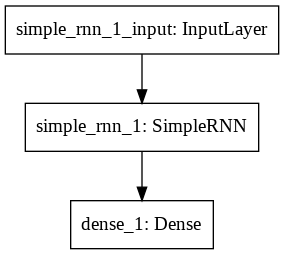

In [ ]:
plot_model(model)

In [ ]:
from keras.datasets import imdb
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.preprocessing import sequence
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
def display_history(history):
  h = history.history
  fig, ax = plt.subplots(1,2, figsize = (8,4))
  plt.subplots_adjust(wspace = 0.5)
  fig.suptitle('Training result')

  ax[0].set_title('Accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].plot(h['acc'])
  ax[0].plot(h['val_acc'])
  
  ax[1].set_title('Loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].plot(h['loss'])
  ax[1].plot(h['val_loss'])
  fig.legend(['train','validation'])

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kiyoonpark","key":"42c6f29b0c804c96556e74c186a22544"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c si650winter11

  0% 0.00/471k [00:00<?, ?B/s]
100% 471k/471k [00:00<00:00, 69.7MB/s]
  0% 0.00/437k [00:00<?, ?B/s]
100% 437k/437k [00:00<00:00, 60.8MB/s]


In [ ]:
from sklearn.model_selection import train_test_split
import collections
import nltk
from keras.layers.core import SpatialDropout1D, Dropout
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
maxlen = 0
word_freqs = collections.Counter()
num_recs = 0

with open('training.txt') as f:
  for line in f:
    data = line.strip().split('\t')
    label, sentence = data[0], data[1]
    words = nltk.word_tokenize(sentence.lower())
    if len(words) > maxlen:
      maxlen = len(words)
    for word in words:
      word_freqs[word] += 1
    num_recs += 1

In [ ]:
print('Max length of words in one sentence:', maxlen)
print('Total # of the words :', len(word_freqs))

Max length of words in one sentence: 42
Total # of the words : 2328


In [ ]:
MAX_FEATURES = 2000
MAX_SEQUENCE_LENGTH = 40

vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word2index = {x[0] : i+2 for i, x in enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index['PAD'] = 0
word2index['UNK'] = 1

index2word = {v : k for k, v in word2index.items()}

In [ ]:
X = np.empty((num_recs, ), dtype = list)
y = np.zeros((num_recs, ))
i = 0

with open('training.txt') as f:
  for line in f:
    data = line.strip().split('\t')
    label, sentence = data[0], data[1]
    words = nltk.word_tokenize(sentence.lower())
    seqs = []
    for word in words:
      if word in word2index.keys():
        seqs.append(word2index[word])
      else : seqs.append(word2index['UNK'])
    X[i] = seqs
    y[i] = int(label)
    i += 1

In [ ]:
print('X.shape :', X.shape)
print('y.shape :', y.shape)

X.shape : (7086,)
y.shape : (7086,)


In [ ]:
X

array([list([5, 10, 9, 12, 101, 17, 48, 22, 4]),
       list([67, 19, 5, 115, 969, 970, 2, 358, 136, 110, 3, 44, 317, 319, 23, 971, 3, 6, 10, 9, 12, 137, 118, 972, 341, 67, 4]),
       list([2, 122, 5, 10, 9, 12, 18, 325, 4]), ...,
       list([34, 2, 303, 96, 3, 156, 5, 304, 26, 220, 3, 2, 58, 305, 38, 73, 37, 2, 306, 5, 26, 11, 13, 4]),
       list([94, 11, 13, 17, 144, 18, 127, 26, 4]),
       list([89, 3, 6, 11, 13, 19, 18, 87, 26, 4])], dtype=object)

In [ ]:
X = sequence.pad_sequences(X, maxlen = MAX_SEQUENCE_LENGTH)
X

array([[  0,   0,   0, ...,  48,  22,   4],
       [  0,   0,   0, ..., 341,  67,   4],
       [  0,   0,   0, ...,  18, 325,   4],
       ...,
       [  0,   0,   0, ...,  11,  13,   4],
       [  0,   0,   0, ..., 127,  26,   4],
       [  0,   0,   0, ...,  87,  26,   4]], dtype=int32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 10

K.clear_session()
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE,
                    input_length = MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           256256    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 40, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 305,729
Trainable params: 305,729
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, validation_data = (X_test, y_test))

Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 18s 3ms/step - loss: 0.2403 - acc: 0.8927 - val_loss: 0.0641 - val_acc: 0.9718
Epoch 2/10
5668/5668 [==============================] - 17s 3ms/step - loss: 0.0259 - acc: 0.9917 - val_loss: 0.0464 - val_acc: 0.9866
Epoch 3/10
5668/5668 [==============================] - 17s 3ms/step - loss: 0.0103 - acc: 0.9966 - val_loss: 0.0419 - val_acc: 0.9824
Epoch 4/10
5668/5668 [==============================] - 17s 3ms/step - loss: 0.0047 - acc: 0.9988 - val_loss: 0.0462 - val_acc: 0.9887
Epoch 5/10
5668/5668 [==============================] - 17s 3ms/step - loss: 0.0024 - acc: 0.9993 - val_loss: 0.0614 - val_acc: 0.9880
Epoch 6/10
5668/5668 [==============================] - 17s 3ms/step - loss: 0.0021 - acc: 0.9995 - val_loss: 0.0451 - val_acc: 0.9908
Epoch 7/10
5668/5668 [==============================] - 18s 3ms/step - loss: 0.0016 - acc: 0.9995 - val_loss: 0.0586 - val_acc: 0.9894
Epoch 8

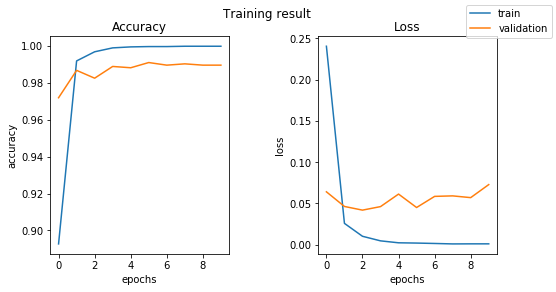

In [ ]:
display_history(history)

In [ ]:
for i in range(4):
  idx = np.random.randint(len(X_test))
  _X_test = X_test[idx].reshape(1,40)
  y_label = y_test[idx]
  y_pred = model.predict(X_test)[0][0]
  sent = ' '.join([index2word[x] for x in _X_test[0].tolist() if x != 0])
  print('%.0f\t%d\t%s' % (y_pred, y_label, sent))

1	0	although watching harry potter was a little boring .
1	0	hopefully , this is not the case , and the acting will have us overlooking the color of their hair . ( trivia : harry potter 's eyes are the wrong color in the movie .
1	0	the da vinci code suck ass..
1	0	and UNK UNK telling me how brokeback mountain sucks so much , but everyone else liked it , so i think i 'll go see it .


In [ ]:
from keras.layers.core import RepeatVector
from keras.layers.recurrent import GRU
from keras.layers.wrappers import TimeDistributed
from keras.utils import np_utils

nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [ ]:
fedata = open('treebank_sents.txt', 'w')
ffdata = open('treebank_poss.txt', 'w')
NOT_PERMITTED = [
                 '-NONE-',
]

sents = nltk.corpus.treebank.tagged_sents()
for sent in sents:
  words, poss = [], []
  for word, pos in sent:
    if pos in NOT_PERMITTED : continue
    words.append(word)
    poss.append(pos)
  fedata.write('{:s}\n'.format(' '.join(words)))
  ffdata.write('{:s}\n'.format(' '.join(poss)))

fedata.close()
ffdata.close()

In [ ]:
!ls

kaggle.json  sample_data       training.txt	  treebank_sents.txt
model.png    testdata.txt.zip  treebank_poss.txt


In [ ]:
def parse_sentences(filename):
  word_freqs = collections.Counter()
  num_recs, maxlen = 0, 0
  with open(filename, 'r') as f:
    for line in f:
      words = line.strip().lower().split()
      for word in words :
        word_freqs[word] += 1
      if len(words) > maxlen : maxlen = len(words)
      num_recs += 1
  return word_freqs, maxlen, num_recs

In [ ]:
s_wordfreqs, s_maxlen, s_numrecs = parse_sentences('treebank_sents.txt')
t_wordfreqs, t_maxlen, t_numrecs = parse_sentences('treebank_poss.txt')

In [ ]:
print('len(s_wordfreqs) :', len(s_wordfreqs))
print('s_maxlen :', s_maxlen)
print('s_numrecs :', s_numrecs)

len(s_wordfreqs) : 10947
s_maxlen : 249
s_numrecs : 3914


In [ ]:
print('len(t_wordfreqs) :', len(t_wordfreqs))
print('t_maxlen :', t_maxlen)
print('t_numrecs :', t_numrecs)

len(t_wordfreqs) : 45
t_maxlen : 249
t_numrecs : 3914


In [ ]:
MAX_SEQLEN = 250
S_MAX_FEATURES = 10947
T_MAX_FEATURES = 45

s_vocabsize = min(len(s_wordfreqs), S_MAX_FEATURES) + 1
s_word2index = {x[0]:i+1 for i, x in enumerate(s_wordfreqs.most_common(S_MAX_FEATURES))}
s_word2index["PAD"] = 0
#s_word2index["UNK"] = 1
s_index2word = {v:k for k, v in s_word2index.items()}

t_vocabsize = len(t_wordfreqs) + 1
t_word2index = {x[0]:i+1 for i, x in enumerate(t_wordfreqs.most_common(T_MAX_FEATURES))}
t_word2index["PAD"] = 0
t_index2word = {v:k for k, v in t_word2index.items()}

In [ ]:
def build_tensor(filename, numrecs, word2index, maxlen, make_categorical = False, num_classes = 0):
    data = np.empty((numrecs, ), dtype=list)
    fin = open(filename, "r")
    i = 0
    for line in fin:
        wids = []
        for word in line.strip().lower().split():
            if word in word2index.keys():
                wids.append(word2index[word])
            else:
                wids.append(word2index['UNK'])
        if make_categorical:
            data[i] = np_utils.to_categorical(wids, num_classes=num_classes)
        else:
            data[i] = wids
            
        i += 1
    fin.close()
    pdata = sequence.pad_sequences(data, maxlen=maxlen)
    return pdata

In [ ]:
X = build_tensor("treebank_sents.txt", s_numrecs, s_word2index, MAX_SEQLEN)
Y = build_tensor("treebank_poss.txt", t_numrecs, t_word2index, MAX_SEQLEN, True, t_vocabsize)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
EMBED_SIZE = 128
HIDDEN_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 6

K.clear_session()
model = Sequential()
model.add(Embedding(s_vocabsize, EMBED_SIZE, input_length=MAX_SEQLEN))
model.add(SpatialDropout1D(0.2))
model.add(GRU(HIDDEN_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(RepeatVector(MAX_SEQLEN))
model.add(GRU(HIDDEN_SIZE, return_sequences=True))
model.add(TimeDistributed(Dense(t_vocabsize)))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 128)          1401344   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 128)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37056     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 250, 64)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 250, 64)           24768     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 250, 46)           2990      
_________________________________________________________________
activation_1 (Activation)    (None, 250, 46)          

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=[X_test, Y_test])

Train on 3131 samples, validate on 783 samples
Epoch 1/6
3131/3131 [==============================] - 86s 27ms/step - loss: 0.3031 - acc: 0.0123 - val_loss: 0.2929 - val_acc: 0.0139
Epoch 2/6
3131/3131 [==============================] - 84s 27ms/step - loss: 0.2860 - acc: 0.0133 - val_loss: 0.2912 - val_acc: 0.0140
Epoch 3/6
3131/3131 [==============================] - 84s 27ms/step - loss: 0.2829 - acc: 0.0141 - val_loss: 0.2873 - val_acc: 0.0153
Epoch 4/6
3131/3131 [==============================] - 84s 27ms/step - loss: 0.2777 - acc: 0.0156 - val_loss: 0.2840 - val_acc: 0.0154
Epoch 5/6
3131/3131 [==============================] - 82s 26ms/step - loss: 0.2747 - acc: 0.0161 - val_loss: 0.2830 - val_acc: 0.0161
Epoch 6/6
3131/3131 [==============================] - 84s 27ms/step - loss: 0.2731 - acc: 0.0165 - val_loss: 0.2820 - val_acc: 0.0159


In [ ]:
loss, acc = model.evaluate(X_test, Y_test)
print('Accuracy :', acc)
print('Loss :', loss)

783/783 [==============================] - 7s 9ms/step
Accuracy : 0.01591315449454547
Loss : 0.2819615081428416


In [ ]:
tagged_sentences = nltk.corpus.treebank.tagged_sents() # 토큰화에 품사 태깅이 된 데이터 받아오기
print("품사 태깅이 된 문장 개수: ", len(tagged_sentences)) # 문장 샘플의 개수 출력

품사 태깅이 된 문장 개수:  3914


In [ ]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


In [ ]:
sentences, pos_tags = [], [] 
for tagged_sentence in tagged_sentences: # 3,914개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 품사 태깅 정보들은 tag_info에 저장한다.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    pos_tags.append(list(tag_info)) # 각 샘플에서 품사 태깅 정보만 저장한다.

In [ ]:
print(sentences[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


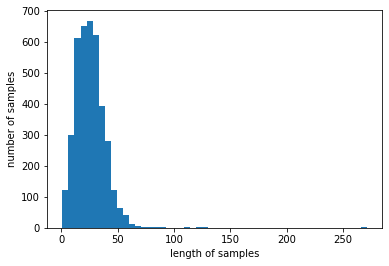

In [ ]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def tokenize(samples):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(samples)
  return tokenizer

In [ ]:
src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)

In [ ]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 11388
태깅 정보 집합의 크기 : 47


In [ ]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

In [ ]:
max_len = 150
X_train = sequence.pad_sequences(X_train, padding='post', maxlen=max_len)
# X_train의 모든 샘플의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
y_train = sequence.pad_sequences(y_train, padding='post', maxlen=max_len)
# y_train의 모든 샘플의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [ ]:
Y_train = np_utils.to_categorical(y_train, num_classes=tag_size)
Y_test = np_utils.to_categorical(y_test, num_classes=tag_size)

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(Y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(Y_test.shape))

훈련 샘플 문장의 크기 : (3131, 150)
훈련 샘플 레이블의 크기 : (3131, 150, 47)
테스트 샘플 문장의 크기 : (783, 150)
테스트 샘플 레이블의 크기 : (783, 150, 47)


In [ ]:
EMBED_SIZE = 128
HIDDEN_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 6

K.clear_session()
model = Sequential()
model.add(Embedding(vocab_size, EMBED_SIZE, input_length = max_len))
model.add(SpatialDropout1D(0.2))
model.add(GRU(HIDDEN_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(RepeatVector(max_len))
model.add(GRU(HIDDEN_SIZE, return_sequences=True))
model.add(TimeDistributed(Dense(tag_size)))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 128)          1457664   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 150, 128)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37056     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 150, 64)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 150, 64)           24768     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 150, 47)           3055      
_________________________________________________________________
activation_1 (Activation)    (None, 150, 47)          

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=6,  validation_data=(X_test, Y_test))

Train on 3131 samples, validate on 783 samples
Epoch 1/6
3131/3131 [==============================] - 16s 5ms/step - loss: 2.7595 - acc: 0.7625 - val_loss: 1.1999 - val_acc: 0.8294
Epoch 2/6
3131/3131 [==============================] - 15s 5ms/step - loss: 1.0492 - acc: 0.8286 - val_loss: 0.8994 - val_acc: 0.8294
Epoch 3/6
3131/3131 [==============================] - 15s 5ms/step - loss: 0.8709 - acc: 0.8286 - val_loss: 0.8430 - val_acc: 0.8294
Epoch 4/6
3131/3131 [==============================] - 15s 5ms/step - loss: 0.8320 - acc: 0.8286 - val_loss: 0.8082 - val_acc: 0.8294
Epoch 5/6
3131/3131 [==============================] - 15s 5ms/step - loss: 0.7825 - acc: 0.8286 - val_loss: 0.7320 - val_acc: 0.8296
Epoch 6/6
3131/3131 [==============================] - 14s 5ms/step - loss: 0.7064 - acc: 0.8313 - val_loss: 0.6736 - val_acc: 0.8353


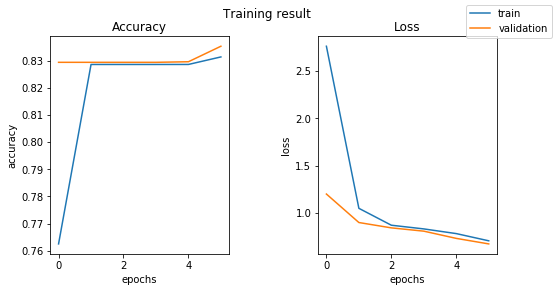

In [ ]:
display_history(history)

In [ ]:
index_to_word=src_tokenizer.index_word
index_to_tag=tar_tokenizer.index_word

i=10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

true = np.argmax(Y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_tag[t].upper(), index_to_tag[pred].upper()))
       

단어             |실제값  |예측값
-----------------------------------
in               : IN      NNP
addition         : NN      NNP
,                : ,       NN
buick            : NNP     NN
is               : VBZ     NN
a                : DT      NN


KeyError: ignored

In [ ]:
from keras.layers.wrappers import Bidirectional

In [ ]:
K.clear_session()
model = Sequential()
model.add(Embedding(vocab_size, EMBED_SIZE, input_length = max_len))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(HIDDEN_SIZE, dropout=0.2, recurrent_dropout=0.2)))
model.add(RepeatVector(max_len))
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size)))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 128)          1457664   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 150, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 150, 128)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150, 128)          98816     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 150, 47)           6063      
_________________________________________________________________
activation_1 (Activation)    (None, 150, 47)          

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=6,  validation_data=(X_test, Y_test))

Train on 3131 samples, validate on 783 samples
Epoch 1/6
3131/3131 [==============================] - 33s 11ms/step - loss: 2.0653 - acc: 0.7919 - val_loss: 1.0128 - val_acc: 0.8294
Epoch 2/6
3131/3131 [==============================] - 31s 10ms/step - loss: 0.9878 - acc: 0.8286 - val_loss: 0.9604 - val_acc: 0.8294
Epoch 3/6
3131/3131 [==============================] - 31s 10ms/step - loss: 0.9259 - acc: 0.8286 - val_loss: 0.8491 - val_acc: 0.8294
Epoch 4/6
3131/3131 [==============================] - 31s 10ms/step - loss: 0.7609 - acc: 0.8286 - val_loss: 0.6574 - val_acc: 0.8294
Epoch 5/6
3131/3131 [==============================] - 31s 10ms/step - loss: 0.6254 - acc: 0.8349 - val_loss: 0.5799 - val_acc: 0.8437
Epoch 6/6
3131/3131 [==============================] - 32s 10ms/step - loss: 0.5867 - acc: 0.8441 - val_loss: 0.5601 - val_acc: 0.8467


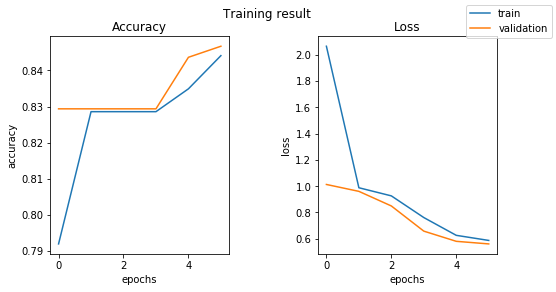

In [ ]:
display_history(history)

In [ ]:
index_to_word=src_tokenizer.index_word
index_to_tag=tar_tokenizer.index_word

i=10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

true = np.argmax(Y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_tag[t].upper(), index_to_tag[pred].upper()))
       

단어             |실제값  |예측값
-----------------------------------
in               : IN      NN
addition         : NN      NN
,                : ,       NN
buick            : NNP     NN
is               : VBZ     NN
a                : DT      NN
relatively       : RB      NN
respected        : VBN     NN
nameplate        : NN      NN
among            : IN      NN
american         : NNP     NN
express          : NNP     NN
card             : NN      NN
holders          : NNS     NN
,                : ,       NN
says             : VBZ     NN
0                : -NONE-  NN
*t*-1            : -NONE-  NN
an               : DT      NN


KeyError: ignored

In [ ]:
index_to_tag

{1: 'nn',
 2: 'in',
 3: 'nnp',
 4: 'dt',
 5: '-none-',
 6: 'nns',
 7: 'jj',
 8: ',',
 9: '.',
 10: 'cd',
 11: 'vbd',
 12: 'rb',
 13: 'vb',
 14: 'cc',
 15: 'to',
 16: 'vbn',
 17: 'vbz',
 18: 'prp',
 19: 'vbg',
 20: 'vbp',
 21: 'md',
 22: 'pos',
 23: 'prp$',
 24: '$',
 25: '``',
 26: "''",
 27: ':',
 28: 'wdt',
 29: 'jjr',
 30: 'nnps',
 31: 'wp',
 32: 'rp',
 33: 'jjs',
 34: 'wrb',
 35: 'rbr',
 36: '-rrb-',
 37: '-lrb-',
 38: 'ex',
 39: 'rbs',
 40: 'pdt',
 41: '#',
 42: 'wp$',
 43: 'ls',
 44: 'fw',
 45: 'uh',
 46: 'sym'}